In [1]:
import re
import nltk
import math
import random
import collections
import scipy as sp
import numpy as np
import pandas as pd
import tensorflow as tf

from collections import deque
from scipy.sparse import hstack
from nltk.corpus import stopwords

from sklearn import decomposition, metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, mean_squared_error, make_scorer, confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text

from utility.processing import processer
from utility.utility import *

%matplotlib inline

In [2]:
train = pd.read_csv('./data/preprocessed_train.csv').fillna('')
test = pd.read_csv('./data/preprocessed_test.csv').fillna('')
idx = test.id.values.astype(int)
y = train.median_relevance.values

In [3]:
sentences = train.apply(lambda x: "%s %s %s" % (x['query_preprocessed'], x['product_title_preprocessed'], x['product_description_preprocessed']), axis=1)  
sentence = sentences.str.cat(sep=' ')   
vocabulary = sentence.split(' ') 
words = vocabulary
unique = collections.Counter(words)
if len(vocabulary)//2 < len(unique):
    n_words = len(vocabulary)//2
else:
    n_words = len(unique)
    
vocabulary_size = n_words
print("단어수 : %d"% len(unique))

단어수 : 22356


In [4]:
def build_dataset(words, n_words):
    unique = collections.Counter(words)            
    orders = unique.most_common(n_words - 1)       
    count = [['UNK', -1]]
    count.extend(orders)

    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary)
        
    ordered_words = list(dictionary.keys())

    data = []
    for word in words:
        if word in dictionary:         
            index = dictionary[word]
        else:
            index = 0                   
            count[0][1] += 1            
        data.append(index)
        
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, ordered_words, reversed_dictionary  

data, count, ordered_words, reversed_dictionary = build_dataset(vocabulary, vocabulary_size)           

#### generate_batch

In [5]:
def generate_batch_skip(data, batch_size, num_skips, skip_window, data_index):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1                     
    assert span > num_skips

    buffer = collections.deque(maxlen=span)

    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)   
        
    for i in range(batch_size // num_skips):
        targets = list(range(span))  
        targets.pop(skip_window)   
        np.random.shuffle(targets)  

        start = i * num_skips             
        batch[start:start+num_skips] = buffer[skip_window]
        
        for j in range(num_skips):
            labels[start+j, 0] = buffer[targets[j]]

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels, data_index

In [6]:
batch, labels, data_index = generate_batch_skip(data, batch_size=16, num_skips=2, skip_window=2, data_index=0)
for i in range(16):
    print(batch[i], reversed_dictionary[batch[i]], '->', labels[i, 0], reversed_dictionary[labels[i, 0]])

41 light -> 1054 christma
41 light -> 47 10
3 set -> 47 10
3 set -> 51 batteri
47 10 -> 364 oper
47 10 -> 3 set
51 batteri -> 364 oper
51 batteri -> 409 multi
364 oper -> 119 led
364 oper -> 51 batteri
409 multi -> 330 train
409 multi -> 364 oper
119 led -> 1054 christma
119 led -> 364 oper
330 train -> 119 led
330 train -> 1054 christma


In [7]:
def generate_batch_cbow(data, batch_size, num_skips, skip_window, data_index):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1                     
    assert span > num_skips

    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)   
        
    for i in range(batch_size // num_skips):
        targets = list(range(span))  
        targets.pop(skip_window)   
        np.random.shuffle(targets)  

        start = i * num_skips      
        labels[start:start+num_skips, 0] = buffer[skip_window]
        
        for j in range(num_skips):
            batch[start+j] = buffer[targets[j]]
            
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels, data_index

In [8]:
batch, labels, data_index = generate_batch_cbow(data, batch_size=16, num_skips=4, skip_window=2, data_index=0)
for i in range(16):
    print(batch[i], reversed_dictionary[batch[i]], '->', labels[i, 0], reversed_dictionary[labels[i, 0]])

1054 christma -> 41 light
47 10 -> 41 light
3 set -> 41 light
119 led -> 41 light
41 light -> 3 set
47 10 -> 3 set
1054 christma -> 3 set
51 batteri -> 3 set
41 light -> 47 10
51 batteri -> 47 10
364 oper -> 47 10
3 set -> 47 10
364 oper -> 51 batteri
409 multi -> 51 batteri
47 10 -> 51 batteri
3 set -> 51 batteri


In [9]:
def generate_batch_pvdm(data, batch_size, num_skips, skip_window, data_index):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1                     
    assert span > num_skips

    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)   
        
    for i in range(batch_size // num_skips):
        targets = list(range(span))  
        targets.pop(skip_window)   
        np.random.shuffle(targets)  

        start = i * num_skips      
        labels[start:start+num_skips, 0] = buffer[skip_window]
        
        for j in range(num_skips):
            batch[start+j] = buffer[targets[j]]
            
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels, data_index

In [10]:
batch, labels, data_index = generate_batch_cbow(data, batch_size=16, num_skips=4, skip_window=2, data_index=0)
for i in range(16):
    print(batch[i], reversed_dictionary[batch[i]], '->', labels[i, 0], reversed_dictionary[labels[i, 0]])

In [11]:
def generate_batch_pvdbow(data, batch_size, num_skips, skip_window, data_index):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1                     
    assert span > num_skips

    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)   
        
    for i in range(batch_size // num_skips):
        targets = list(range(span))  
        targets.pop(skip_window)   
        np.random.shuffle(targets)  

        start = i * num_skips      
        labels[start:start+num_skips, 0] = buffer[skip_window]
        
        for j in range(num_skips):
            batch[start+j] = buffer[targets[j]]
            
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels, data_index

In [12]:
batch, labels, data_index = generate_batch_cbow(data, batch_size=16, num_skips=4, skip_window=2, data_index=0)
for i in range(16):
    print(batch[i], reversed_dictionary[batch[i]], '->', labels[i, 0], reversed_dictionary[labels[i, 0]])

#### modeling

In [13]:
np.random.seed(1)
tf.set_random_seed(1)

batch_size = 256
embedding_size = 256    
skip_window = 2         
num_skips = 4           
num_sampled = 64        

valid_size = 16      
valid_window = 100 
valid_examples = np.random.choice(valid_window, valid_size, replace=False)  

In [14]:
for i in np.random.choice(valid_window, valid_size, replace=False)  :
    print(reversed_dictionary[i], end=', ')

perfect, green, featur, memori, new, 4, control, cream, wide, set, shirt, UNK, woman, comfort, pillow, durabl, 

In [15]:
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

truncated = tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size))

nce_weights = tf.Variable(truncated)
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# nce_loss
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,\
                                     biases=nce_biases,\
                                     labels=train_labels,\
                                     inputs=embed,\
                                     num_sampled=num_sampled,\
                                     num_classes=vocabulary_size))

# SGD
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))

normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

#### train

In [16]:
%%time

num_steps = 100001           

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    average_loss, data_index = 0, 0
    for step in range(num_steps):
#         batch_inputs, batch_labels, data_index = generate_batch_skip(data, batch_size, num_skips, skip_window, data_index)
        batch_inputs, batch_labels, data_index = generate_batch_cbow(data, batch_size, num_skips, skip_window, data_index)
        
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 5000 == 0:
            if step > 0:
                average_loss /= 5000
            print('Average loss at step {} : {}'.format(step, average_loss))
            average_loss = 0

        if step % 10000 == 0:
            sim = similarity.eval()        

            for i in range(valid_size):
                valid_word = ordered_words[valid_examples[i]]

                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]

    final_embeddings = normalized_embeddings.eval()

Average loss at step 0 : 258.99041748046875
Average loss at step 5000 : 35.619104258298876
Average loss at step 10000 : 6.269825718450546
Average loss at step 15000 : 4.691312129116058
Average loss at step 20000 : 4.321929677796364
Average loss at step 25000 : 4.152782947087288
Average loss at step 30000 : 4.042320091843605
Average loss at step 35000 : 3.951409832930565
Average loss at step 40000 : 3.8734836279153826
Average loss at step 45000 : 3.8171364413261415
Average loss at step 50000 : 3.7579862778663635
Average loss at step 55000 : 3.718468474674225
Average loss at step 60000 : 3.666844993233681
Average loss at step 65000 : 3.6343116249322893
Average loss at step 70000 : 3.596901454329491
Average loss at step 75000 : 3.5634975395798683
Average loss at step 80000 : 3.531087826526165
Average loss at step 85000 : 3.499805892622471
Average loss at step 90000 : 3.4761315448522567
Average loss at step 95000 : 3.4581494611859322
Average loss at step 100000 : 3.4365313745737076
Wall ti

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    final_embeddingss = normalized_embeddings.eval()

In [18]:
# np.save('./model/w2v_qt', final_embeddings)
# final_embeddings = np.load('./model/w2v.npy')

#### Visualization

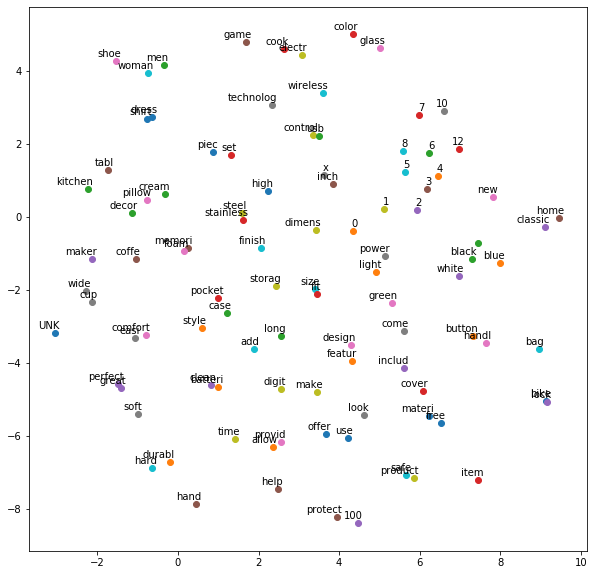

In [19]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(10, 10))       
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i]

        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

    plot_only = 0
    how_many = 100
    low_dim_embs = tsne.fit_transform(final_embeddings[plot_only:plot_only+how_many])     
    labels = ordered_words[plot_only:plot_only+how_many]                                  

    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

In [20]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

In [21]:
slicer = int(len(train) * 0.9)
y_dev = y[slicer:]
y = y[:slicer]

dev_query = train_query[slicer:]
train_query = train_query[:slicer]

dev_title = train_title[slicer:]
train_title = train_title[:slicer]

In [22]:
stop_words = text.ENGLISH_STOP_WORDS.union(['http','www','img','border','color','style','padding','table','font', \
                                            'thi','inch','ha','width','height','0','1','2','3','4','5','6','7','8','9'])
stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))

tfv = text.TfidfVectorizer(min_df=3,  max_features=None, strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}', \
                      ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words = stop_words)


full_data = train_query + train_title
tfv.fit(full_data)

idf_dict = dict(zip(tfv.get_feature_names(), tfv.idf_))
idf_dict['UNK'] = np.array(list(idf_dict.values())).mean()

In [23]:
w2n_dict = dict(zip(reversed_dictionary.values(), reversed_dictionary.keys()))

In [24]:
def w2d2v(x):
    avg = 0
    for w in x.split(" "):
        if w not in w2n_dict:
            embedding_vec = final_embeddings[w2n_dict['UNK']]
        else :
            embedding_vec = final_embeddings[w2n_dict[w]]
            
        if w not in idf_dict:
            idf_w = idf_dict['UNK']
        else :
            idf_w = idf_dict[w]
            
        avg += embedding_vec * idf_w
    avg /= len(train_title[0].split(" "))
    return avg

In [25]:
train['query_vec'] = train.apply(lambda x: w2d2v(x['query_preprocessed']), axis=1)
train['title_vec'] = train.apply(lambda x: w2d2v(x['product_title_preprocessed']), axis=1)
train['query_title_vec'] = train.apply(lambda x: w2d2v(x['query_preprocessed'] + x['product_title_preprocessed']), axis=1)
train['query_title_cos'] = train.apply(lambda x: metric.cos_sim(x['query_vec'], x['title_vec']), axis=1)

In [26]:
XX = train.drop(['median_relevance', 'relevance_variance'], axis=1)
yy = train['median_relevance']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.1, random_state=0)

In [28]:
df_train = pd.DataFrame.from_records(X_train['query_title_vec'].values)
df_test = pd.DataFrame.from_records(X_test['query_title_vec'].values)

svm = SVC(C = 100, gamma='auto')
svm_result = svm.fit(df_train, y_train)

svm_pred_train = svm_result.predict(df_train)
svm_pred_test = svm_result.predict(df_test)

kappa
train : 0.623977	dev : 0.470349
rmse
train : 0.805459	dev : 0.957770

confusion_matrix : 1016개중 344개를 틀림
 [[ 22  13   8  34]
 [ 12  39  22  81]
 [  7  24  29 126]
 [  2   4  11 582]]

classification_report :
               precision    recall  f1-score   support

           1       0.51      0.29      0.37        77
           2       0.49      0.25      0.33       154
           3       0.41      0.16      0.23       186
           4       0.71      0.97      0.82       599

    accuracy                           0.66      1016
   macro avg       0.53      0.42      0.44      1016
weighted avg       0.61      0.66      0.60      1016



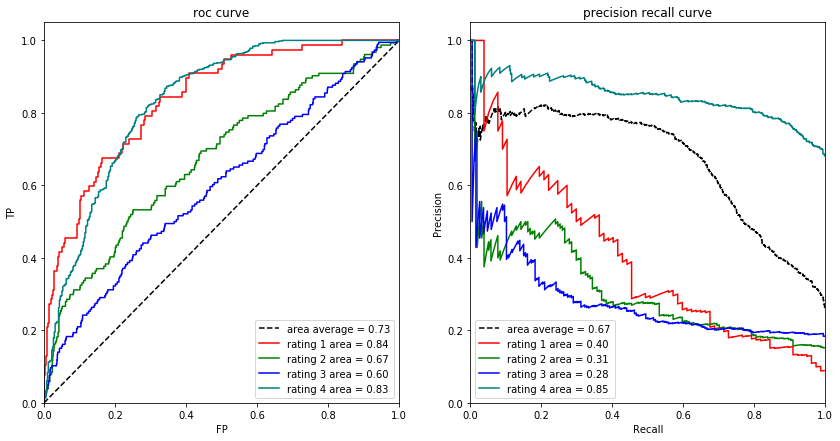

In [29]:
print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_train, svm_pred_train), \
                                      metric.quadratic_weighted_kappa(y_test, svm_pred_test)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_train, svm_pred_train)**0.5, \
                                     mean_squared_error(y_test, svm_pred_test)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_test), len(np.where(svm_pred_test!=y_test)[0])), \
      metrics.confusion_matrix(y_test, svm_pred_test))
print('\nclassification_report :\n', classification_report(y_test, svm_pred_test))

plot_multiclass_roc_prc(svm, df_test, y_test, save=False)